In [101]:
import sqlite3
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
# Creating an empty database
Path("bank.db").touch()

# Connect to database
conn = sqlite3.connect("bank.db")
c = conn.cursor()

# Creating a table
c.execute(
    """CREATE TABLE bank (
    age int, job text,
    marital text, education text,
    default_e text, balance int,
    housing text, loan text,
    contact text, day int,
    month text, duration int,
    campaign int, pdays text,
    previous int, poutcome text,
    deposit text
    );"""
)

In [104]:
# Import pandas to work with data sets
import pandas as pd

# Open csv file and drop any null values
bank = pd.read_csv("/Users/david/Desktop/Projects/SQL:Python/bank.csv")
bank.dropna()

# Add table to database
#This line below is a bit tricky since it'll drop the existing table and create a new one based on the DataFrame.
conn.execute("DROP TABLE IF EXISTS bank")
bank.to_sql("bank", conn, if_exists="append", index=False)

11162

In [105]:
#Just checking columns to make sure I'm not missing anything
print(bank.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')


In [106]:
from pandasql import sqldf

#Which professions are the most popular among customers over 45 years old?
sqldf('''SELECT job, count(*) AS job_count 
         FROM bank 
         WHERE age > 45 
         GROUP BY job 
         ORDER BY job_count DESC;
''')

'''
    With this SQL Query, we see that most are retired with a count of 764, followed by people working 
    in management with a count of 757. In third place, people with blue collar jobs with a count of 537.
    Feel free to check out the rest in the table.

'''



'\n    With this SQL Query, we see that most are retired with a count of 764, followed by people working \n    in management with a count of 757. In third place, people with blue collar jobs with a count of 537.\n    Feel free to check out the rest in the table.\n\n'

In [107]:
for column in bank.select_dtypes(include='object').columns:
    print(column)
    print(bank[column].unique())

job
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital
['married' 'single' 'divorced']
education
['secondary' 'tertiary' 'primary' 'unknown']
default
['no' 'yes']
housing
['yes' 'no']
loan
['no' 'yes']
contact
['unknown' 'cellular' 'telephone']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome
['unknown' 'other' 'failure' 'success']
deposit
['yes' 'no']


In [108]:
categorical_cols = []
for feature in bank.columns:
    if ((bank[feature].dtypes == 'O') and (feature not in ['deposits'])):
        categorical_cols.append(feature)
        
#Just checking all the categorial features so we can create visualizations
print(categorical_cols)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')


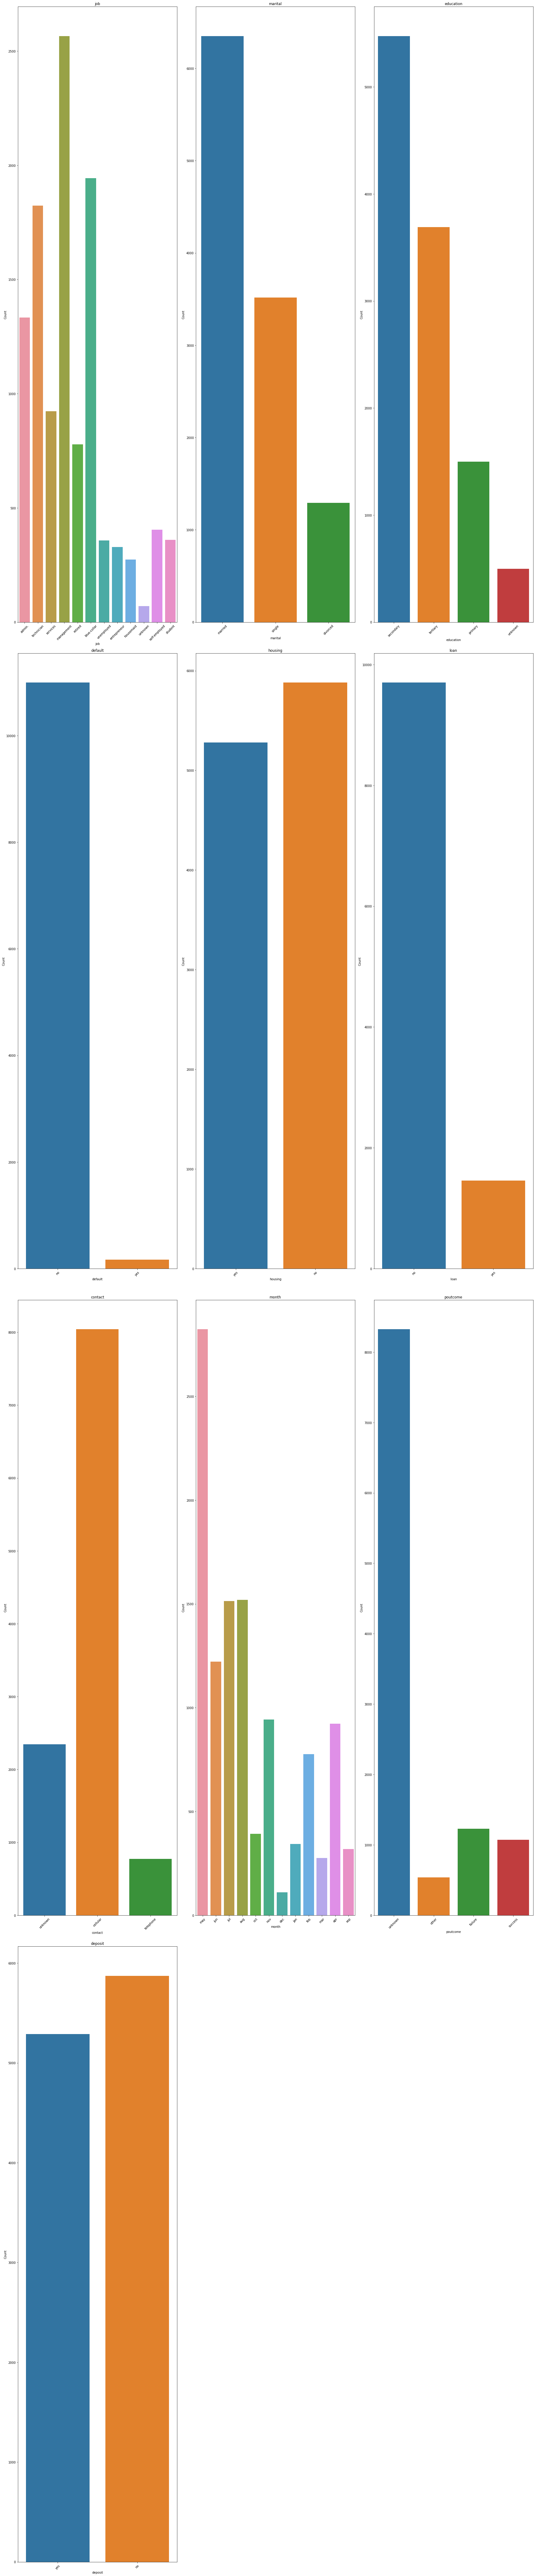

In [110]:
print(bank.columns)

num_plots = len(categorical_cols) #Number of loops to run through
num_cols = 3  # Number of columns in each row
num_rows = int(np.ceil(num_plots / num_cols))  #Calculates the number of rows

#Increases the width to avoid overcramping
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 120), facecolor='white')  

#flatten the axes if there is more than one row
axes = axes.flatten()

#Loops through the categorical features
for i, categorical_feature in enumerate(categorical_cols):
    sns.countplot(x=categorical_feature, data=bank, ax=axes[i], orient='v')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(categorical_feature)
    axes[i].set_title(categorical_feature)
    axes[i].tick_params(axis='x', rotation=45)  #Rotate x-axis labels since the job names overlapped

# Hide any empty subplots
for j in range(num_plots, num_rows * num_cols):
    axes[j].axis('off')    

#Show the plots
plt.tight_layout()
plt.show()

In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [112]:
bank['deposit'].groupby(bank['deposit']).count()


deposit
no     5873
yes    5289
Name: deposit, dtype: int64

In [113]:


newData = bank.copy(deep = True)
newData.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [114]:
print(bank.columns)

#print(newData.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')


In [115]:
'''
    This can be used as correlation between defaulting and the number of deposits made
    after looking, typically wether one person deposits or not the number of default 
    loans is less than the loans that don't. However the number of defaulted loans is higher 
    in the people who made no deposits. This could be due to numerous things but it is a 
    key note of loan succession. 
'''


newData.groupby(['deposit','default']).size()



deposit  default
no       no         5757
         yes         116
yes      no         5237
         yes          52
dtype: int64

In [116]:
'''
    From here on out we'll be focusing on featuring engineering, we already handled dropping
    the Nan values so now we'll go into looking for outliers and narrowing down what number of data
    we'll use in our model

'''
newData.drop(['default'],axis=1, inplace=True)

deposit  pdays
no       -1       4940
          1          2
          2          6
          5          2
          6          2
                  ... 
yes       804        1
          805        1
          828        1
          842        1
          854        1
Length: 732, dtype: int64


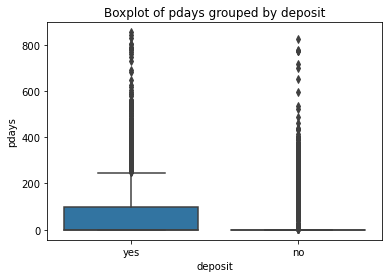

In [117]:
print(newData.groupby(['deposit','pdays']).size())

sns.boxplot(x='deposit', y='pdays', data=newData)
plt.title('Boxplot of pdays grouped by deposit')
plt.show()

'''
    Here we can see that we get a -1 at 4940 of the no positions and to be sure of any other
    instances we graphed it and saw the no's were practically nothing and the average was hovering around the 0,
    so we'll classify this column as an outlier and drop it

'''

newData.drop(['pdays'],axis=1, inplace=True)

In [118]:
# remove outliers in feature balance...
newData.groupby(['deposit','balance'],sort=True)['balance'].count()

#This column won't be removed because it's an even spread for different answers, we want variance

deposit  balance
no       -6847      1
         -2712      1
         -2282      1
         -2049      1
         -1965      1
                   ..
yes       34646     1
          36252     1
          45248     1
          52587     2
          81204     2
Name: balance, Length: 5082, dtype: int64

In [119]:
newData.groupby('age',sort=True)['age'].count()
'''
    These values are good, there are no "out of the ordinary" values, such that the ages seem normal.
    we probably won't use them but at least we know theres variance and no outliers. 
    This ranges from 18 - 95 years old.

'''

'\n    These values are good, there are no "out of the ordinary" values, such that the ages seem normal.\n    we probably won\'t use them but at least we know theres variance and no outliers. \n    This ranges from 18 - 95 years old.\n\n'

In [120]:
newData.groupby(['deposit','campaign'],sort=True)['campaign'].count()
'''
    These have variance so there's no need to eliminate the column, HOWEVER, the no deposite section of the
    campaign jumps from 33, into larger numbers, which is a key sign of outliers, especially since the yes
    portion of the campaign stops at 32, so for simplicity sake we'll treat 32 as the max and eliminate 
    anything beyond as outliers. 

'''

"\n    These have variance so there's no need to eliminate the column, HOWEVER, the no deposite section of the\n    campaign jumps from 33, into larger numbers, which is a key sign of outliers, especially since the yes\n    portion of the campaign stops at 32, so for simplicity sake we'll treat 32 as the max and eliminate \n    anything beyond as outliers. \n\n"

In [121]:
#Establishing the new data frame with all outliers eliminated and sorted. 
ThirdDataFrame = newData[newData['campaign'] < 32]

In [122]:
#Making sure everything moved over
ThirdDataFrame.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,deposit
0,59,admin.,married,secondary,2343,yes,no,unknown,5,may,1042,1,0,unknown,yes
1,56,admin.,married,secondary,45,no,no,unknown,5,may,1467,1,0,unknown,yes
2,41,technician,married,secondary,1270,yes,no,unknown,5,may,1389,1,0,unknown,yes
3,55,services,married,secondary,2476,yes,no,unknown,5,may,579,1,0,unknown,yes
4,54,admin.,married,tertiary,184,no,no,unknown,5,may,673,2,0,unknown,yes


In [123]:
ThirdDataFrame.groupby(['deposit','previous'],sort=True)['previous'].count()

'''
    Upon looking at this we see that the numbers don't correlate too well as the previous column gets higher,
    after looking the numbers take a large spike around the 28-30 range for both no and yes deposits.
    So we figured a good spot to cut off outliers was 29, its right in the middle of 28 and 30, and at 29 it's
    a perfect 24 numbers for both no and yes deposites.

'''
FourthDataFrame = ThirdDataFrame[ThirdDataFrame['previous'] < 31]


In [124]:
'''
    As the last part of feature engineering, we need to mask column data and create dummy variables. 
    We'll separate the categorical features from before and the remaining columns that are made up of 
    phrases like yes and no

'''

"\n    As the last part of feature engineering, we need to mask column data and create dummy variables. \n    We'll separate the categorical features from before and the remaining columns that are made up of \n    phrases like yes and no\n\n"

In [125]:
categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
# Use get_dummies on categorical columns and drop the original columns
FourthDataFrame = pd.get_dummies(FourthDataFrame, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_', drop_first=True, dummy_na=False)

In [126]:
FourthDataFrame.head()

,age,balance,housing,loan,day,duration,campaign,previous,deposit,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343,yes,no,5,1042,1,0,yes,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,56,45,no,no,5,1467,1,0,yes,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,41,1270,yes,no,5,1389,1,0,yes,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,55,2476,yes,no,5,579,1,0,yes,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,54,184,no,no,5,673,2,0,yes,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [127]:
remaining_cols = ['housing', 'deposit', 'loan']

#As an experiment we tried using the lambda function
FourthDataFrame[remaining_cols] = FourthDataFrame[remaining_cols].apply(lambda col: col.apply(lambda x: 1 if x == 'yes' else 0))

#One liner for loop
new_column_names = [col + '_new' for col in remaining_cols]
FourthDataFrame.rename(columns=dict(zip(remaining_cols, new_column_names)), inplace=True)

In [128]:
FourthDataFrame.head()

,age,balance,housing_new,loan_new,day,duration,campaign,previous,deposit_new,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343,1,0,5,1042,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,56,45,0,0,5,1467,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,41,1270,1,0,5,1389,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,55,2476,1,0,5,579,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,54,184,0,0,5,673,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [157]:
'''
    Now the last part of the model, creating the train test model and outputting a confusion matrix.
    This entails splitting the dataset into a training and testing portion. 

'''
from sklearn.model_selection import train_test_split

X = FourthDataFrame.drop(['deposit_new'],axis=1)
Y = FourthDataFrame['deposit_new']

#We decided a 70/30 split was enough to train the data and then test it. 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print(len(X_train))

print(len(X_test))

7805
3345


In [158]:
#A couple more imports we'll use here
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier


In [168]:
print("Cross-validated scores:", cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5, scoring='accuracy'))
print("Mean cross-validated score:", cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5, scoring='accuracy').mean())

Cross-validated scores: [0.85393978 0.85201794 0.84304933 0.85393978 0.86098655]
Mean cross-validated score: 0.8541960281870595


In [161]:
model_xgb = XGBClassifier(objective='binary:logistic',learning_rate=0.1,max_depth=10,n_estimators=100)

In [162]:
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [166]:
Finaloutput = confusion_matrix(y_test,model_xgb.predict(X_test))
print(Finaloutput)

[[1489  310]
 [ 177 1369]]


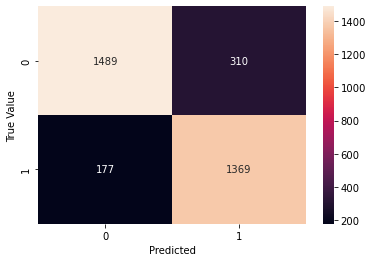

In [167]:
sns.heatmap(Finaloutput, annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Value')
plt.show()

In [165]:
'''
    In summary,
    The model correctly predicted 1369 instances as positive (True Positives).
    The model correctly predicted 1489 instances as negative (True Negatives).
    The model made 310 false positive predictions (False Positives).
    The model made 177 false negative predictions (False Negatives).

    This means our accuracy, True Positives + True negatives divided by all 4 combined, resulting 
    an accuracy of roughly 85%
    
'''

'\n    In summary,\n    The model correctly predicted 1369 instances as positive (True Positives).\n    The model correctly predicted 1489 instances as negative (True Negatives).\n    The model made 310 false positive predictions (False Positives).\n    The model made 177 false negative predictions (False Negatives).\n\n    This means our accuracy, True Positives + True negatives divided by all 4 combined, resulting \n    an accuracy of roughly 85%\n    \n'